In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import tensorflow as tf
import json
import zipfile
import shutil

from PIL import Image
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau



In [2]:
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3
TRAIN_DATASET_DIR = './lab5/DogsVsCats/train/train/'

In [3]:
filenames = os.listdir(TRAIN_DATASET_DIR)
categories = []

for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [4]:
df.head()

,filename,category
0,cat.0.jpg,0
1,cat.1.jpg,0
2,cat.10.jpg,0
3,cat.100.jpg,0
4,cat.1000.jpg,0


In [5]:
df.tail()

,filename,category
24995,dog.9995.jpg,1
24996,dog.9996.jpg,1
24997,dog.9997.jpg,1
24998,dog.9998.jpg,1
24999,dog.9999.jpg,1


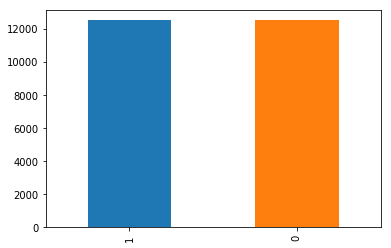

In [6]:
df['category'].value_counts().plot.bar()

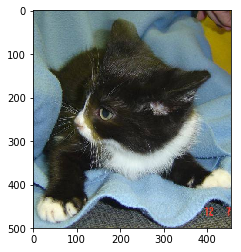

In [7]:
sample = random.choice(filenames)
image = load_img(TRAIN_DATASET_DIR+sample)
plt.imshow(image)

In [8]:
model = tf.keras.Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0

In [9]:
earlystop = EarlyStopping(patience=10)

In [10]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [11]:
callbacks = [earlystop, learning_rate_reduction]

In [12]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) 

Train dataset is 20000 samples.
Validate dataset is 5000 samples.

In [13]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

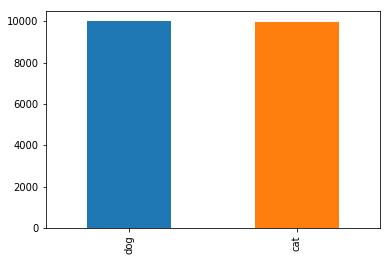

In [14]:
train_df['category'].value_counts().plot.bar()

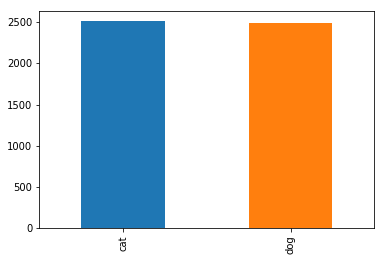

In [15]:
validate_df['category'].value_counts().plot.bar()

In [16]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

Generating batches of tensor image data with real-time data augmentation:

In [17]:
train_datagen = ImageDataGenerator(
    rotation_range=13,        #Int. Degree range for random rotations
    rescale=1./255,           #Rescaling factor. Multiply the data by the value provided (after applying all other transformations)    
    shear_range=0.1,          #Shear Intensity (Shear angle in counter-clockwise direction in degrees)  
    zoom_range=0.2,           #Range for random zoom
    horizontal_flip=True,     #Randomly flip inputs horizontally
    width_shift_range=0.1,    #Indicates the percentage of the width of the image to shift
    height_shift_range=0.1    ##Indicates the percentage of the height of the image to shift
)

#Takes the dataframe and the path to a directory and generates batches of augmented/normalized data
train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "./lab5/DogsVsCats/train/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical', #2D numpy array of one-hot encoded labels
    batch_size=batch_size     #15
)

Found 20000 validated image filenames belonging to 2 classes.


In [18]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "./lab5/DogsVsCats/train/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)


Found 5000 validated image filenames belonging to 2 classes.


In [19]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "./lab5/DogsVsCats/train/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


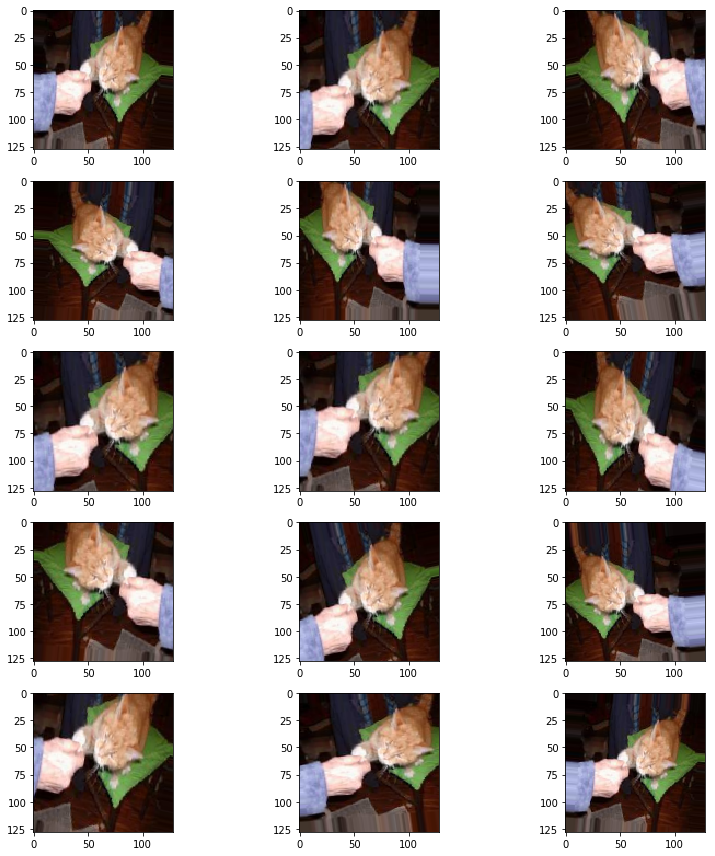

In [20]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [21]:
epochs=5

history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/5
1333/1333 [==============================] - 2284s 2s/step - loss: 0.7602 - accuracy: 0.6263 - val_loss: 0.5767 - val_accuracy: 0.7229
Epoch 2/5
1333/1333 [==============================] - 2196s 2s/step - loss: 0.5672 - accuracy: 0.7155 - val_loss: 0.5723 - val_accuracy: 0.7053
Epoch 3/5
1333/1333 [==============================] - 1995s 1s/step - loss: 0.5176 - accuracy: 0.7507 - val_loss: 0.4989 - val_accuracy: 0.7483
Epoch 4/5
1333/1333 [==============================] - 1971s 1s/step - loss: 0.4805 - accuracy: 0.7750 - val_loss: 0.4360 - val_accuracy: 0.7972
Epoch 5/5
1333/1333 [==============================] - 2341s 2s/step - loss: 0.4466 - accuracy: 0.7951 - val_loss: 0.4888 - val_accuracy: 0.7848


In [22]:
model.save_weights("model.h5")

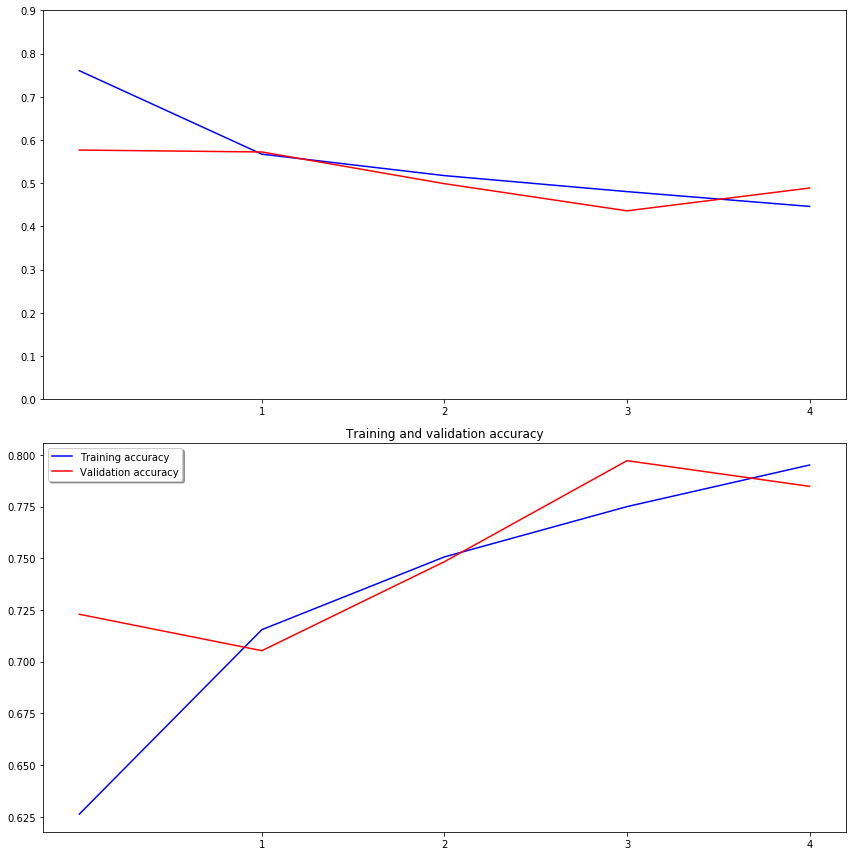

In [23]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))
plt.title('Training and validation loss')

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.title('Training and validation accuracy')
plt.tight_layout()
plt.show()

In [24]:
test_filenames = os.listdir("./lab5/DogsVsCats/test1/test1")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [25]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "./lab5/DogsVsCats/test1/test1/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 12500 validated image filenames.


In [26]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

In [27]:
test_df['category'] = np.argmax(predict, axis=-1)

In [28]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

In [29]:
test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

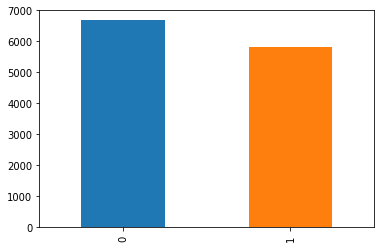

In [30]:
test_df['category'].value_counts().plot.bar()

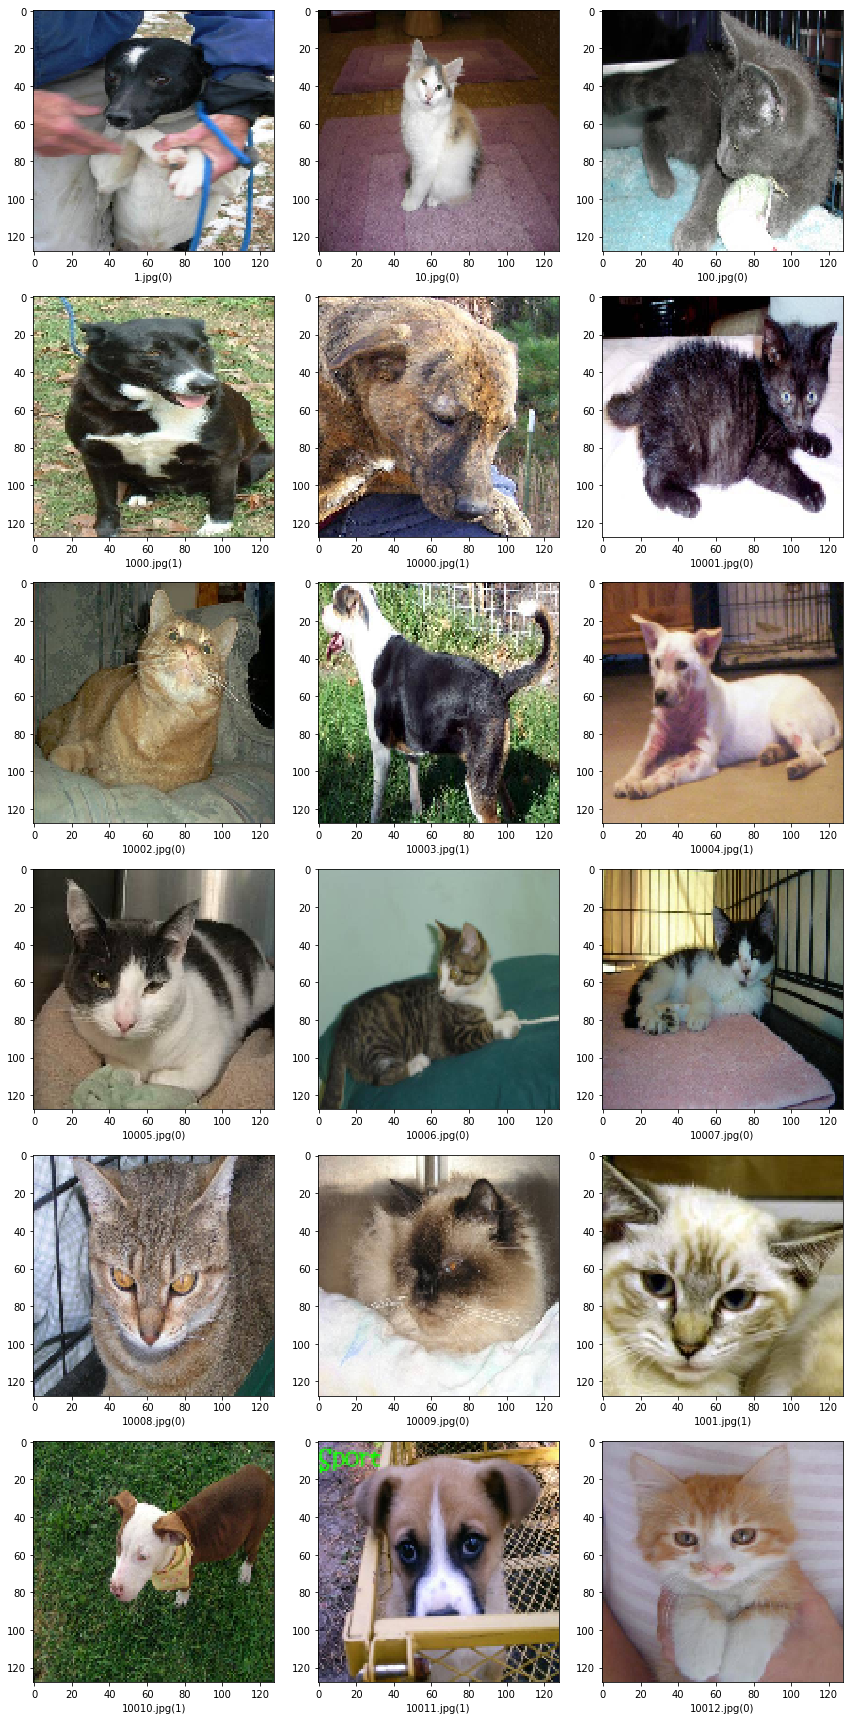

In [31]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("./lab5/DogsVsCats/test1/test1/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

In [32]:
submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['label'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)
submission_df.to_csv('submission.csv', index=False)